In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")

In [2]:
import kagglehub, os
path = kagglehub.dataset_download("vijayvvenkitesh/microsoft-stock-time-series-analysis")
df = pd.read_csv(os.path.join(path, "Microsoft_Stock.csv"))

In [3]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")
df.set_index("Date", inplace=True)

# We'll model the Close price
data = df["Close"]

In [4]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(np.array(data).reshape(-1, 1)).flatten()



In [5]:
test_obs = 28
train = data_scaled[:-test_obs]
test = data_scaled[-test_obs:]

In [6]:
trend_opts = ["add", "mul", None]
seasonal_opts = ["add", "mul", None]
seasonal_periods = 7  # weekly seasonality (adjust if monthly data etc.)

best_rmse = float("inf")
best_cfg = None
best_model = None

print("🔍 Selecting best (trend, seasonality)...\n")



🔍 Selecting best (trend, seasonality)...



In [8]:

for t in trend_opts:
    for s in seasonal_opts:
        try:
            model = ExponentialSmoothing(
                train,
                trend=t,
                seasonal=s,
                seasonal_periods=seasonal_periods
            ).fit(optimized=True, use_brute=True)
            forecast = model.forecast(len(test))
            rmse = mean_squared_error(test, forecast, squared=False)
            print(f"trend={t}, seasonal={s} | RMSE={rmse:.4f}")
            if rmse < best_rmse:
                best_rmse = rmse
                best_cfg = (t, s)
                best_model = model
        except:
            continue
print(f"\n✅ Best trend/seasonal = {best_cfg} | RMSE = {best_rmse:.4f}")            

trend=add, seasonal=add | RMSE=0.0506
trend=add, seasonal=None | RMSE=0.0519
trend=None, seasonal=add | RMSE=0.0415
trend=None, seasonal=None | RMSE=0.0428

✅ Best trend/seasonal = (None, 'add') | RMSE = 0.0415


In [9]:
forecast = best_model.forecast(len(test))

In [10]:
test_inv = scaler.inverse_transform(test.reshape(-1, 1)).flatten()
forecast_inv = scaler.inverse_transform(forecast.reshape(-1, 1)).flatten()

In [11]:
rmse = mean_squared_error(test_inv, forecast_inv, squared=False)
mape = mean_absolute_percentage_error(test_inv, forecast_inv)

print("\n📊 Performance Summary:")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape*100:.2f}%")



📊 Performance Summary:
RMSE: 8.504
MAPE: 3.39%


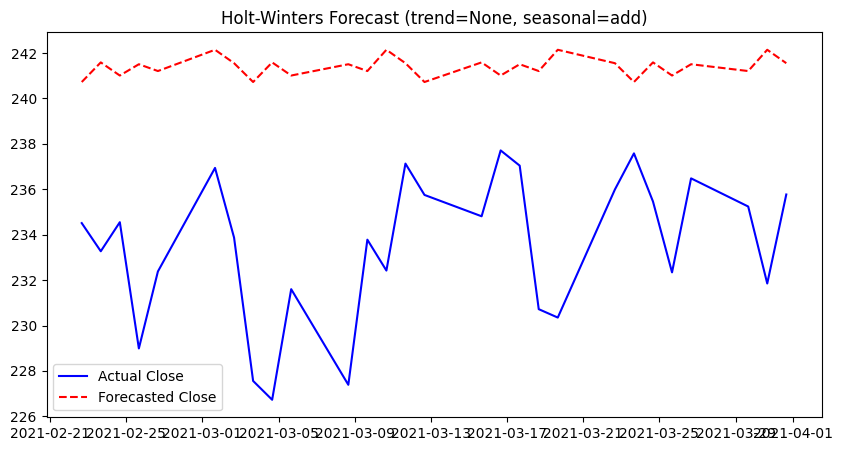

In [12]:
plt.figure(figsize=(10,5))
plt.plot(df.index[-test_obs:], test_inv, label="Actual Close", color="blue")
plt.plot(df.index[-test_obs:], forecast_inv, label="Forecasted Close", color="red", linestyle="--")
plt.title(f"Holt-Winters Forecast (trend={best_cfg[0]}, seasonal={best_cfg[1]})")
plt.legend()
plt.show()